In [69]:
import os
import math
import numpy as np
import scipy as sp
import pandas as pd
import ujson as json
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

In [70]:
shas, groups = zip(*[x.split(',') for x in open('../datasets/training/samples_by_packer_group.txt').read().splitlines()])
sha_group = {a: int(b) for a, b in zip(shas, groups)}
sha_label = {a: 1 if int(b) else 0 for a, b in zip(shas, groups)}
shas = list(sha_label.keys())
reportPath = "../datasets/training/reports/{}/{}.json"
newFeaturesPath = "../datasets/training/new-features/{}/{}.json"

### Data preparation - extracting features from jsons

In [71]:
#All features used are listed here.
'''['entropy', 'api_num', 'avg_ent', 'max_entropy', 'risky_section', 'size',
       'sizeOfCode', 'stackReserve', 'sizeOfInitializedData',
       'sizeOfUninitializedData', 'majorLinkerVersion', 'baseOfData',
       'minorLinkerVersion', 'executable_sections', 'writable_sections',
       'readble_sections', 'init_data', 'uninit_data', 'readble_writable',
       'writable_executable', 'uninit_executable', 'frequencyMedian',
       'frequencyExpected', 'frequencyQr', 'frequencyStdDev',
       'frequencySkewness', 'frequencyQl', 'frequencyIRQ',
       'localEntropiesMedian', 'localEntropiesExpected', 'localEntropiesQr',
       'localEntropiesStdDev', 'localEntropiesSkewness', 'localEntropiesQl',
       'localEntropiesIRQ', 'readble_writable_sqr',
       'writable_readable_executable', 'startEntropy50', 'startEntropy100',
       'startEntropy150', 'charIFD', 'apiNameK32', 'adressesApiList',
       'apiFunctions-GetCurrentProcess', 'apiFunctions-GetProcAddress',
       'apiFunctions-LoadLibraryA', 'apiFunctions-CloseHandle',
       'apiFunctions-WideCharToMultiByte', 'apiFunctions-ExitProcess',
       'certEntropy', 'section-.rsrc', 'section-.text', 'section-.data',
       'section-.reloc', 'section-.rdata', 'section-NO_NAME', 'section-pec1',
       'section-.imports', 'section-pec2', 'section-___OTHER']'''

"['entropy', 'api_num', 'avg_ent', 'max_entropy', 'risky_section', 'size',\n       'sizeOfCode', 'stackReserve', 'sizeOfInitializedData',\n       'sizeOfUninitializedData', 'majorLinkerVersion', 'baseOfData',\n       'minorLinkerVersion', 'executable_sections', 'writable_sections',\n       'readble_sections', 'init_data', 'uninit_data', 'readble_writable',\n       'writable_executable', 'uninit_executable', 'frequencyMedian',\n       'frequencyExpected', 'frequencyQr', 'frequencyStdDev',\n       'frequencySkewness', 'frequencyQl', 'frequencyIRQ',\n       'localEntropiesMedian', 'localEntropiesExpected', 'localEntropiesQr',\n       'localEntropiesStdDev', 'localEntropiesSkewness', 'localEntropiesQl',\n       'localEntropiesIRQ', 'readble_writable_sqr',\n       'writable_readable_executable', 'startEntropy50', 'startEntropy100',\n       'startEntropy150', 'charIFD', 'apiNameK32', 'adressesApiList',\n       'apiFunctions-GetCurrentProcess', 'apiFunctions-GetProcAddress',\n       'apiFunct

In [72]:
frameData = {}
entropy = []
frameData['entropy'] = entropy
api = []
frameData['api_num'] = api
section_entropies = []
frameData['avg_ent'] = section_entropies
max_entropy = []
frameData['max_entropy'] = max_entropy
risky_section = []
frameData['risky_section'] = risky_section
size = []
frameData['size'] = size
sizeOfCode = []
frameData['sizeOfCode'] = sizeOfCode
stackReserve = []
frameData['stackReserve'] = stackReserve
sizeOfInitializedData = []
frameData['sizeOfInitializedData'] = sizeOfInitializedData
sizeOfUninitializedData = []
frameData['sizeOfUninitializedData'] = sizeOfUninitializedData
majorLinkerVersion = []
frameData['majorLinkerVersion'] = majorLinkerVersion
baseOfData = []
frameData['baseOfData'] = baseOfData
minorLinkerVersion = []
frameData['minorLinkerVersion'] = minorLinkerVersion

executable_sections = []
frameData['executable_sections'] = executable_sections
writable_sections = []
frameData['writable_sections'] = writable_sections
readble_sections = []
frameData['readble_sections'] = readble_sections
init_data = []
frameData['init_data'] = init_data
uninit_data = []
frameData['uninit_data'] = uninit_data
readble_writable = []
frameData['readble_writable'] = readble_writable
writable_executable = []
frameData['writable_executable'] = writable_executable
uninit_executable = []
frameData['uninit_executable'] = uninit_executable
frequencyMedian = []
frameData['frequencyMedian'] = frequencyMedian
frequencyExpected = []
frameData['frequencyExpected'] = frequencyExpected
frequencyQr = []
frameData['frequencyQr'] = frequencyQr
frequencyStdDev = []
frameData['frequencyStdDev'] = frequencyStdDev
frequencySkewness = []
frameData['frequencySkewness'] = frequencySkewness
frequencyQl = []
frameData['frequencyQl'] = frequencyQl
frequencyIRQ = []
frameData['frequencyIRQ'] = frequencyIRQ

localEntropiesMedian = []
frameData['localEntropiesMedian'] = localEntropiesMedian
localEntropiesExpected = []
frameData['localEntropiesExpected'] = localEntropiesExpected
localEntropiesQr = []
frameData['localEntropiesQr'] = localEntropiesQr
localEntropiesStdDev = []
frameData['localEntropiesStdDev'] = localEntropiesStdDev
localEntropiesSkewness = []
frameData['localEntropiesSkewness'] = localEntropiesSkewness
localEntropiesQl = []
frameData['localEntropiesQl'] = localEntropiesQl
localEntropiesIRQ = []
frameData['localEntropiesIRQ'] = localEntropiesIRQ

readble_writable_sqr = []
frameData['readble_writable_sqr'] = readble_writable_sqr
writable_readable_executable = []
frameData['writable_readable_executable'] = writable_readable_executable

startEntropy50 = []
frameData['startEntropy50'] = startEntropy50
startEntropy100 = []
frameData['startEntropy100'] = startEntropy100
startEntropy150 = []
frameData['startEntropy150'] = startEntropy150

charIFD = []
frameData['charIFD'] = charIFD

#api stuff
apiNameK32 = [] #KERNEL32.dll 
frameData['apiNameK32'] = apiNameK32

adressesApiList = []
frameData['adressesApiList'] = adressesApiList
#api functions
apiFunctions = ['GetCurrentProcess', 'GetProcAddress', 'LoadLibraryA', 'CloseHandle', 'WideCharToMultiByte', 'ExitProcess']
apiFunctionsCount = {}
for apiFunction in apiFunctions:
    apiFunctionsCount[apiFunction] = []
    frameData['apiFunctions-' + apiFunction] = apiFunctionsCount[apiFunction]

certEntropy = []
frameData['certEntropy'] = certEntropy

# Pick top x
otherSection = '___OTHER'
sections = ['.rsrc', '.text', '.data', '.reloc', '.rdata', 'NO_NAME', 'pec1', '.imports', 'pec2', otherSection]
sectionsCount = {}
for section in sections:
    sectionsCount[section] = []
    frameData['section-' + section] = sectionsCount[section]

for sha in tqdm(shas):
    report = json.load(
        open(reportPath.format(sha[-2:], sha), 'rb')
    )
    newFeatures = json.load(
        open(newFeaturesPath.format(sha[-2:], sha), 'rb')
    )

    frequencyMedian.append(newFeatures['frequency']['median'])
    frequencyExpected.append(newFeatures['frequency']['expected'])
    frequencyQr.append(newFeatures['frequency']['qr'])
    frequencyQl.append(newFeatures['frequency']['ql'])
    frequencyIRQ.append(newFeatures['frequency']['IRQ'])
    frequencySkewness.append(newFeatures['frequency']['skewness'])
    frequencyStdDev.append(newFeatures['frequency']['stdDev'])

    localEntropiesMedian.append(newFeatures['localEntropies']['median'])
    localEntropiesExpected.append(newFeatures['localEntropies']['expected'])
    localEntropiesQr.append(newFeatures['localEntropies']['qr'])
    localEntropiesQl.append(newFeatures['localEntropies']['ql'])
    localEntropiesIRQ.append(newFeatures['localEntropies']['IRQ'])
    localEntropiesSkewness.append(newFeatures['localEntropies']['skewness'])
    localEntropiesStdDev.append(newFeatures['localEntropies']['stdDev'])

    startEntropy50.append(newFeatures['startEntropy'][50])
    startEntropy100.append(newFeatures['startEntropy'][100])
    startEntropy150.append(newFeatures['startEntropy'][150])

    entry = report['coreReport']['entries']['entry_list'][0]
    entropy.append(float(entry['info']['file']['entropy']))
    size.append(int(entry['info']['file']['size'],0))

    if 'imports' not in entry['metadata']['application']['pe']:
        api.append(0)
    else :
        if 'api_list' in entry['metadata']['application']['pe']['imports']['import_list'][-1]:
            api.append( len(entry['metadata']['application']['pe']['imports']['import_list'][-1]['api_list'] ))
        else:
            api.append(0)

    if 'optionalHeader' not in entry['metadata']['application']['pe']:
        sizeOfCode.append(0)
        sizeOfInitializedData.append(0)
        sizeOfUninitializedData.append(0)
        majorLinkerVersion.append(0)
        stackReserve.append(0)
        baseOfData.append(0)
        minorLinkerVersion.append(0)
    else:
        sizeOfCode.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfCode'],0))
        sizeOfInitializedData.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfInitializedData'],0))
        sizeOfUninitializedData.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfUninitializedData'],0))
        majorLinkerVersion.append(int(entry['metadata']['application']['pe']['optionalHeader']['majorLinkerVersion'],0))
        stackReserve.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfStackReserve'],0))
        baseOfData.append(int(entry['metadata']['application']['pe']['optionalHeader']['baseOfData'],0))
        minorLinkerVersion.append(int(entry['metadata']['application']['pe']['optionalHeader']['minorLinkerVersion'],0))

    if 'sections' not in entry['metadata']['application']['pe']:
        for section in sections:
            sectionsCount[section].append(0)
        executable_sections.append(0)
        writable_sections.append(0)
        readble_sections.append(0)
        init_data.append(0)
        uninit_data.append(0)
        readble_writable.append(0)
        writable_executable.append(0)
        uninit_executable.append(0)
    else:
        currSections = {}
        for section in sections:
            currSections[section] = 0
        for sec in entry['metadata']['application']['pe']['sections']['section_list']:
            if sec.get('name', 'NO_NAME') in sections:
                currSections[sec.get('name', 'NO_NAME')] += 1
            else:
                currSections[otherSection] += 1
        for section in sections:
            sectionsCount[section].append(currSections[section])
        en = [sec.get('entropy', 'NO_NAME')
            for sec in entry['metadata']['application']['pe']['sections']['section_list']]
        en = [float(i) for i in en]
        flags = [sec.get('flags')
            for sec in entry['metadata']['application']['pe']['sections']['section_list']]
        ex = 0
        w = 0
        r = 0
        init = 0
        unit = 0
        rw = 0
        we = 0
        wre = 0
        ue = 0
        for flag in flags:
            if( flag != None):
                flag = flag['flag_list']
                if 'IMAGE_SCN_CNT_INITIALIZED_DATA' in flag:
                    init = init+1
                if 'IMAGE_SCN_CNT_UNINITIALIZED_DATA' in flag:
                    unit = unit +1
                if 'IMAGE_SCN_MEM_EXECUTE' in flag:
                    ex = ex + 1
                if 'IMAGE_SCN_MEM_READ' in flag:
                    r = r + 1
                if ('IMAGE_SCN_MEM_WRITE' in flag) & ('IMAGE_SCN_MEM_EXECUTE' in flag):
                    we = we + 1
                if ('IMAGE_SCN_MEM_WRITE' in flag) & ('IMAGE_SCN_MEM_READ' in flag):
                    rw = rw + 1
                if ('IMAGE_SCN_MEM_WRITE' in flag):
                    w = w + 1
                if ('IMAGE_SCN_MEM_EXECUTE' in flag) & ('IMAGE_SCN_CNT_UNINITIALIZED_DATA' in flag):
                    ue = ue + 1
                if ('IMAGE_SCN_MEM_WRITE' in flag) & ('IMAGE_SCN_MEM_EXECUTE' in flag) & ('IMAGE_SCN_MEM_READ' in flag):
                    wre = wre + 1

        uninit_executable.append(ue)
        writable_readable_executable.append(wre)
        readble_writable.append(rw)
        readble_writable_sqr.append(rw**2)
        writable_executable.append(we)
        risky_section.append(sum(x > 7.0 for x in en))
        max_entropy.append(max(en))
        executable_sections.append(ex)
        init_data.append(init)
        uninit_data.append(unit)
        writable_sections.append(w)
        readble_sections.append(r)
        section_entropies.append(sum(en) / len(en))
    #characteristics list
    try:
        characteristics_list = entry['metadata']['application']['pe']['fileHeader']['characteristics']['characteristic_list']
        characteristics_list = map(str, characteristics_list)
        charIFD.append(int('IMAGE_FILE_DLL' in characteristics_list))
    except:
        pass

    #apistuffs
    currApiNameK32 = 0 #KERNEL32.dll 
    currApiNameA32 = 0 #ADVAPI32.dll
    currApiNameU32 = 0 #USER32.dll 
    currAdressesApiList = 0
    currApiFunctions = {}
    for apiFunction in apiFunctions:
        currApiFunctions[apiFunction] = 0
    if 'imports' in entry['metadata']['application']['pe']:
        if 'import_list' in entry['metadata']['application']['pe']['imports']:
            import_list = entry['metadata']['application']['pe']['imports']['import_list']
            for imp in import_list:
                if str(imp['name']) == 'KERNEL32.dll':
                    currApiNameK32 += 1
                if str(imp['name']) == 'ADVAPI32.dll':
                    currApiNameA32 += 1
                if str(imp['name']) == 'USER32.dll':
                    currApiNameU32 += 1
                if 'api_list' in imp:
                    for apis in imp['api_list']:
                        if str(apis).startswith('0x'):
                            currAdressesApiList += 1
                        if str(apis) in apiFunctions:
                            currApiFunctions[str(apis)] += 1
    for apiFunction in apiFunctions:
        apiFunctionsCount[apiFunction].append(currApiFunctions[apiFunction])
    apiNameK32.append(currApiNameK32)
    adressesApiList.append(currAdressesApiList)

    # certificates
    cEnt = 0
    if 'tags' in entry:
        if 'tag_list' in entry['tags']:
            for tag in entry['tags']['tag_list']:
                cEnt += (int(str(tag) == 'entropy'))
    certEntropy.append(cEnt)






  0%|          | 0/43784 [00:00<?, ?it/s]




  0%|          | 32/43784 [00:00<02:19, 313.81it/s]




  0%|          | 75/43784 [00:00<02:48, 259.57it/s]




  0%|          | 151/43784 [00:00<01:55, 379.31it/s]




  0%|          | 182/43784 [00:00<02:00, 360.53it/s]




  0%|          | 212/43784 [00:00<02:26, 296.51it/s]




  1%|          | 238/43784 [00:00<02:34, 280.96it/s]




  1%|          | 291/43784 [00:00<02:23, 304.00it/s]




  1%|          | 361/43784 [00:01<02:07, 341.37it/s]




  1%|          | 404/43784 [00:01<02:41, 267.91it/s]




  1%|          | 442/43784 [00:01<02:43, 264.88it/s]




  1%|          | 520/43784 [00:01<02:27, 293.99it/s]




  2%|▏         | 756/43784 [00:01<01:47, 399.58it/s]




  2%|▏         | 1073/43784 [00:01<01:19, 538.65it/s]




  3%|▎         | 1387/43784 [00:02<01:03, 662.98it/s]




  4%|▎         | 1621/43784 [00:02<00:57, 739.41it/s]




  4%|▍         | 1834/43784 [00:02<00:52, 795.84it/s]




  5%|▍         | 2071/43784 [00:02<

 53%|█████▎    | 23383/43784 [00:19<00:16, 1218.07it/s]




 54%|█████▍    | 23559/43784 [00:19<00:16, 1220.49it/s]




 55%|█████▍    | 23869/43784 [00:19<00:16, 1230.17it/s]




 55%|█████▌    | 24107/43784 [00:19<00:15, 1232.18it/s]




 56%|█████▌    | 24301/43784 [00:19<00:15, 1228.95it/s]




 56%|█████▌    | 24550/43784 [00:19<00:15, 1235.28it/s]




 57%|█████▋    | 24855/43784 [00:19<00:15, 1244.37it/s]




 57%|█████▋    | 25115/43784 [00:20<00:14, 1250.94it/s]




 58%|█████▊    | 25348/43784 [00:20<00:14, 1253.04it/s]




 58%|█████▊    | 25590/43784 [00:20<00:14, 1257.69it/s]




 59%|█████▉    | 25798/43784 [00:22<00:15, 1142.88it/s]




 59%|█████▉    | 25947/43784 [00:23<00:16, 1087.36it/s]




 60%|█████▉    | 26055/43784 [00:24<00:16, 1052.41it/s]




 60%|█████▉    | 26134/43784 [00:25<00:17, 1035.88it/s]




 60%|█████▉    | 26195/43784 [00:25<00:17, 1021.44it/s]




 60%|█████▉    | 26242/43784 [00:25<00:17, 1015.76it/s]




 60%|██████    | 26282/43784 [00:26<00:1

 81%|████████  | 35392/43784 [00:43<00:10, 817.66it/s]




 81%|████████  | 35443/43784 [00:43<00:10, 811.68it/s]




 81%|████████  | 35483/43784 [00:43<00:10, 810.47it/s]




 81%|████████  | 35521/43784 [00:43<00:10, 809.33it/s]




 81%|████████  | 35564/43784 [00:43<00:10, 808.34it/s]




 81%|████████▏ | 35626/43784 [00:44<00:10, 806.72it/s]




 82%|████████▏ | 35690/43784 [00:44<00:10, 806.22it/s]




 82%|████████▏ | 35756/43784 [00:44<00:09, 805.44it/s]




 82%|████████▏ | 35804/43784 [00:44<00:09, 802.02it/s]




 82%|████████▏ | 35922/43784 [00:44<00:09, 802.18it/s]




 82%|████████▏ | 35975/43784 [00:44<00:09, 800.80it/s]




 82%|████████▏ | 36023/43784 [00:45<00:09, 796.79it/s]




 82%|████████▏ | 36062/43784 [00:45<00:09, 795.41it/s]




 82%|████████▏ | 36099/43784 [00:45<00:09, 794.47it/s]




 83%|████████▎ | 36136/43784 [00:46<00:09, 784.76it/s]




 83%|████████▎ | 36178/43784 [00:46<00:09, 775.64it/s]




 83%|████████▎ | 36254/43784 [00:46<00:09, 775.58it/s]



In [73]:
dframe = pd.DataFrame(data=frameData)
shaFrame= pd.DataFrame(data={'sha1': shas})
shaFrame['group'] = [sha_group[sha1] for sha1 in tqdm(shaFrame.sha1.values)]
shaFrame['label'] = [sha_label[sha1] for sha1 in tqdm(shaFrame.sha1.values)]
labels = shaFrame['label'].values
groups = shaFrame['group'].values
shas = shaFrame['sha1'].values






  0%|          | 0/43784 [00:00<?, ?it/s]




100%|██████████| 43784/43784 [00:00<00:00, 2386560.01it/s]




  0%|          | 0/43784 [00:00<?, ?it/s]




100%|██████████| 43784/43784 [00:00<00:00, 2351267.62it/s]

### Training the model

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib

clf = RandomForestClassifier(n_estimators=40, max_features=17, max_depth=30, n_jobs=8, random_state=42)
clf.fit(dframe, labels)
joblib.dump(clf, '../model.pkl')

['../model.pkl']

### Evaluating (5-fold crossvalidation) and displaying violin plots

In [74]:
from sklearn.model_selection import StratifiedKFold

accuracy_whole = []
group_acc = [[],[],[],[],[]]
skf = StratifiedKFold(n_splits=5, random_state=None)

for _ in tqdm(range(6)):
    whole = []
    groups_acc_tmp = [[],[],[],[],[]]
    for train_index, test_index in skf.split(dframe, labels, groups=groups):
        print(train_index)
        print(test_index)
        clf = RandomForestClassifier(n_estimators=40, max_depth=30, max_features=17, n_jobs=8)
        clf.fit(dframe.iloc[train_index], labels[train_index])
        pred = clf.predict(dframe.iloc[test_index])
        whole.append(accuracy_score(pred, labels[test_index]))
        for i in range(5):
            m = np.where(groups[test_index] == i)[0]
            y_preds = clf.predict(dframe.iloc[test_index].iloc[m])
            acc = accuracy_score(labels[test_index][m], (y_preds > 0.5).astype(np.int8))
            groups_acc_tmp[i].append(acc)
    accuracy_whole.append(sum(whole)/5)
    for i in range(5):
        group_acc[i].append(sum(groups_acc_tmp[i])/5)






  0%|          | 0/6 [00:00<?, ?it/s]

[ 7120  7121  7122 ... 43781 43782 43783]
[    0     1     2 ... 12631 12632 12633]
[    0     1     2 ... 43781 43782 43783]
[ 7120  7121  7122 ... 25387 25399 25407]
[    0     1     2 ... 43781 43782 43783]
[13626 13627 13628 ... 34025 34026 34027]
[    0     1     2 ... 43781 43782 43783]
[20113 20114 20116 ... 38936 38937 38938]
[    0     1     2 ... 38936 38937 38938]
[28003 28004 28005 ... 43781 43782 43783]







 17%|█▋        | 1/6 [00:10<00:53, 10.66s/it]

[ 7120  7121  7122 ... 43781 43782 43783]
[    0     1     2 ... 12631 12632 12633]
[    0     1     2 ... 43781 43782 43783]
[ 7120  7121  7122 ... 25387 25399 25407]
[    0     1     2 ... 43781 43782 43783]
[13626 13627 13628 ... 34025 34026 34027]
[    0     1     2 ... 43781 43782 43783]
[20113 20114 20116 ... 38936 38937 38938]
[    0     1     2 ... 38936 38937 38938]
[28003 28004 28005 ... 43781 43782 43783]







 33%|███▎      | 2/6 [00:21<00:42, 10.73s/it]

[ 7120  7121  7122 ... 43781 43782 43783]
[    0     1     2 ... 12631 12632 12633]
[    0     1     2 ... 43781 43782 43783]
[ 7120  7121  7122 ... 25387 25399 25407]
[    0     1     2 ... 43781 43782 43783]
[13626 13627 13628 ... 34025 34026 34027]
[    0     1     2 ... 43781 43782 43783]
[20113 20114 20116 ... 38936 38937 38938]
[    0     1     2 ... 38936 38937 38938]
[28003 28004 28005 ... 43781 43782 43783]







 50%|█████     | 3/6 [00:32<00:32, 10.70s/it]

[ 7120  7121  7122 ... 43781 43782 43783]
[    0     1     2 ... 12631 12632 12633]
[    0     1     2 ... 43781 43782 43783]
[ 7120  7121  7122 ... 25387 25399 25407]
[    0     1     2 ... 43781 43782 43783]
[13626 13627 13628 ... 34025 34026 34027]
[    0     1     2 ... 43781 43782 43783]
[20113 20114 20116 ... 38936 38937 38938]
[    0     1     2 ... 38936 38937 38938]
[28003 28004 28005 ... 43781 43782 43783]







 67%|██████▋   | 4/6 [00:42<00:21, 10.67s/it]

[ 7120  7121  7122 ... 43781 43782 43783]
[    0     1     2 ... 12631 12632 12633]
[    0     1     2 ... 43781 43782 43783]
[ 7120  7121  7122 ... 25387 25399 25407]
[    0     1     2 ... 43781 43782 43783]
[13626 13627 13628 ... 34025 34026 34027]
[    0     1     2 ... 43781 43782 43783]
[20113 20114 20116 ... 38936 38937 38938]
[    0     1     2 ... 38936 38937 38938]
[28003 28004 28005 ... 43781 43782 43783]







 83%|████████▎ | 5/6 [00:53<00:10, 10.72s/it]

[ 7120  7121  7122 ... 43781 43782 43783]
[    0     1     2 ... 12631 12632 12633]
[    0     1     2 ... 43781 43782 43783]
[ 7120  7121  7122 ... 25387 25399 25407]
[    0     1     2 ... 43781 43782 43783]
[13626 13627 13628 ... 34025 34026 34027]
[    0     1     2 ... 43781 43782 43783]
[20113 20114 20116 ... 38936 38937 38938]
[    0     1     2 ... 38936 38937 38938]
[28003 28004 28005 ... 43781 43782 43783]







100%|██████████| 6/6 [01:04<00:00, 10.71s/it]






<IPython.core.display.Javascript object>


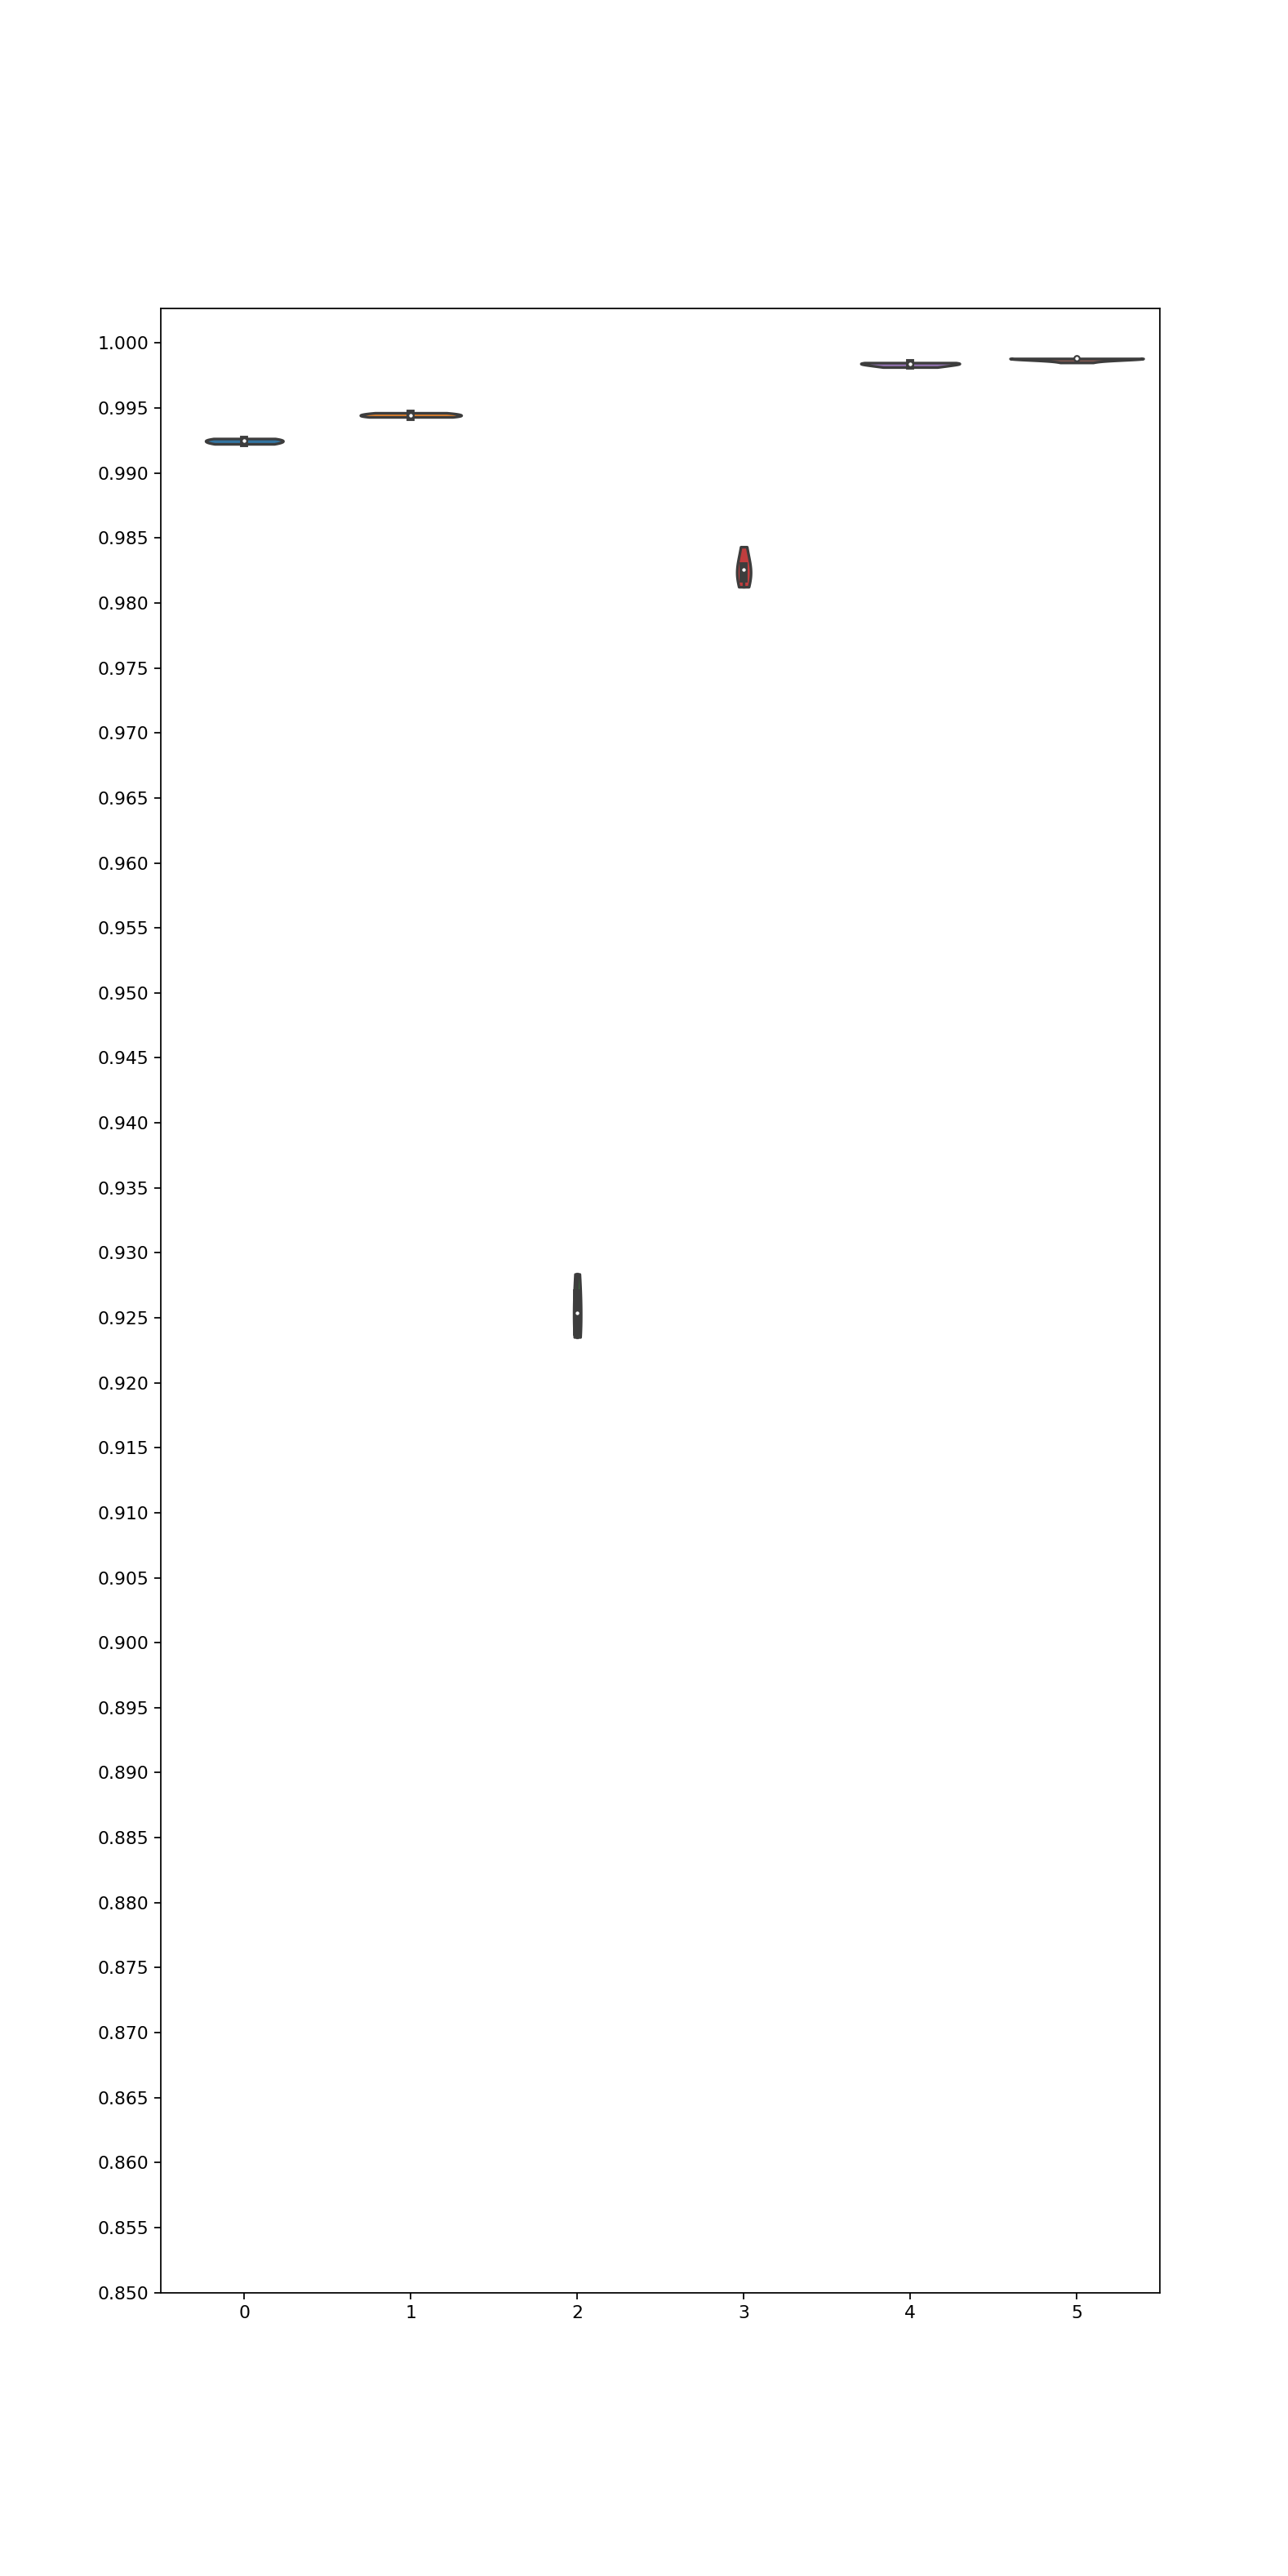

In [75]:
import seaborn as sns
plt.figure(figsize=(10, 20))
sns.violinplot(data=[accuracy_whole, group_acc[0], group_acc[1], group_acc[2], group_acc[3], group_acc[4]] , orient='v', cut=0, bw=1)
plt.yticks(np.arange(0.85, 1, 0.005))
plt.show()

### Displaying random forest feature importance

<IPython.core.display.Javascript object>


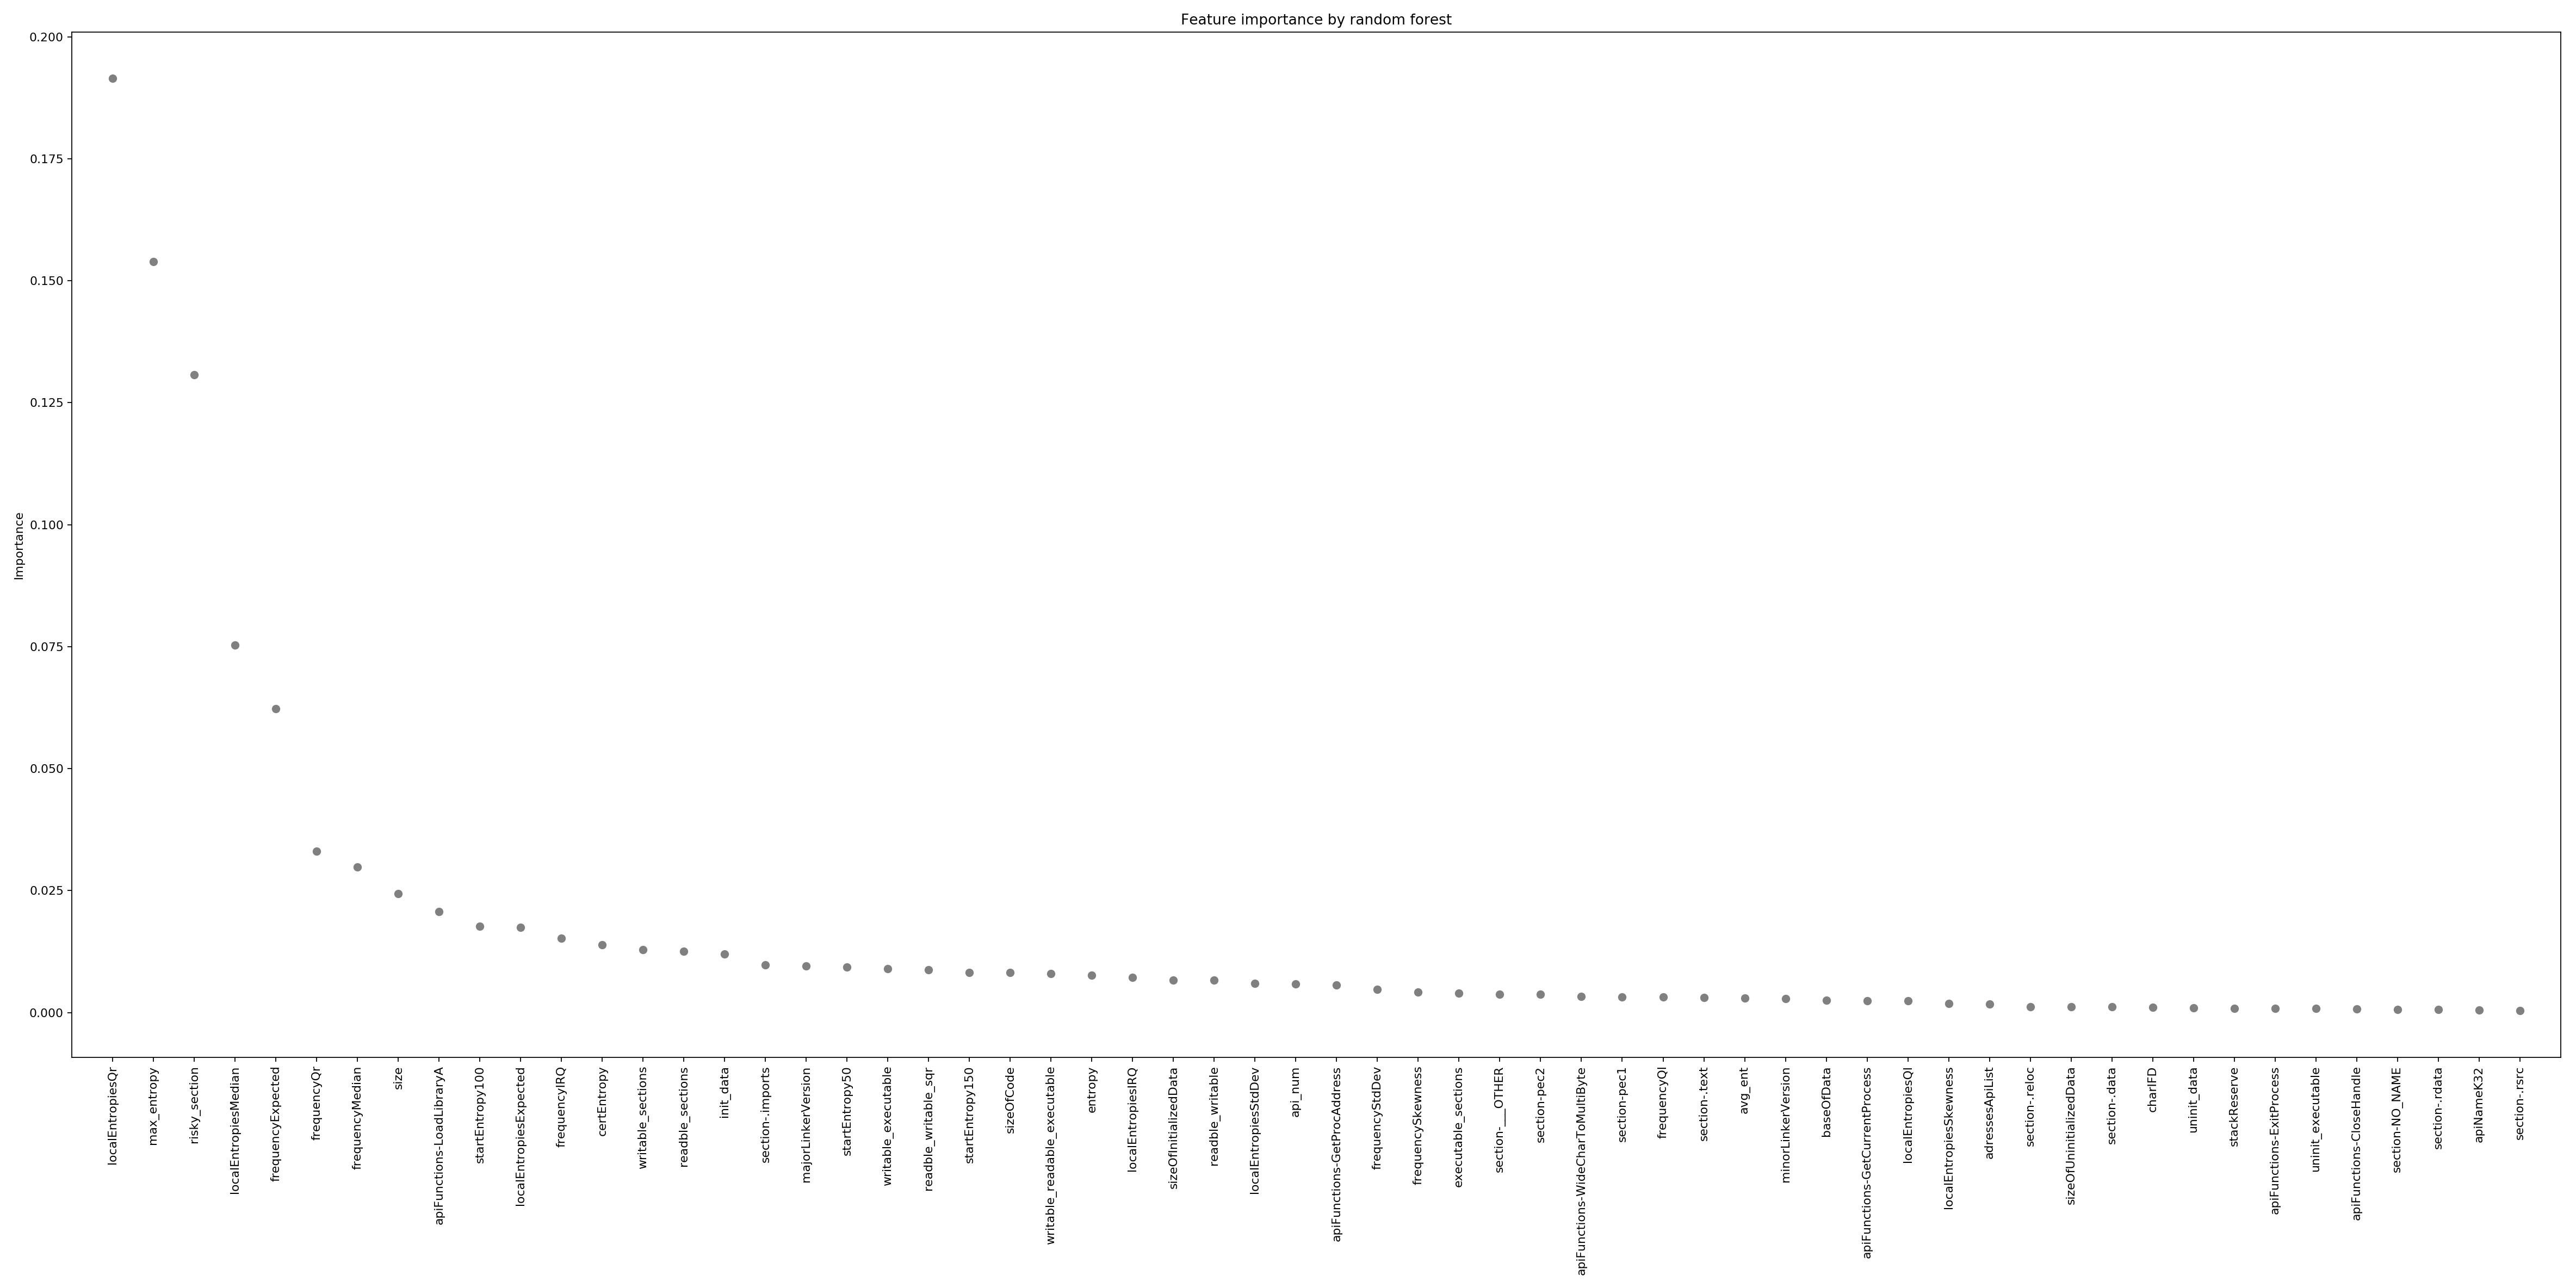

In [44]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(30,15))
plt.plot(range(X_train.shape[1]), importances[indices], 'o', color='gray')
plt.title('Feature importance by random forest')
plt.ylabel('Importance')
plt.xlim([-1, X_train.shape[1]])
plt.xticks(range(X_train.shape[1]), dframe.columns.values[indices], rotation=90)
plt.tight_layout()
plt.show()

### Recursively removing features and displaying results

In [208]:
from sklearn.feature_selection import RFE

results = {}
# max was 83 before
for num_features in tqdm(range(60, 40, -2)):
    X_train, X_val, y_train, y_val = train_test_split(
            dframe, labels, test_size=0.2, stratify=groups
        )
    results[str(num_features)] = []
    rfe_rf = RFE(RandomForestClassifier(n_estimators=40,random_state=0,n_jobs=-1), n_features_to_select=num_features, step=1)
    rfe_rf.fit(X_train, y_train)
    for _ in range(100):
        X_train, X_val, y_train, y_val = train_test_split(
            dframe[dframe.columns[rfe_rf.get_support()]], labels, test_size=0.2, stratify=groups
        )
        m_train = list(map(int, X_train.index))
        m_val = list(map(int, X_val.index))

        #clf = DecisionTreeClassifier()
        clf = RandomForestClassifier(n_estimators=40, max_features=17, max_depth=30, n_jobs=6)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_val)
        results[str(num_features)].append(accuracy_score(pred, y_val))









  0%|          | 0/13 [00:00<?, ?it/s]







  8%|▊         | 1/13 [01:30<18:07, 90.65s/it]







 15%|█▌        | 2/13 [03:00<16:33, 90.35s/it]







 23%|██▎       | 3/13 [04:41<15:39, 93.99s/it]







 31%|███       | 4/13 [06:30<14:38, 97.62s/it]







 38%|███▊      | 5/13 [08:15<13:12, 99.09s/it]







 46%|████▌     | 6/13 [10:07<11:48, 101.18s/it]







 54%|█████▍    | 7/13 [12:05<10:21, 103.66s/it]







 62%|██████▏   | 8/13 [14:05<08:48, 105.73s/it]







 69%|██████▉   | 9/13 [16:10<07:11, 107.82s/it]







 77%|███████▋  | 10/13 [18:27<05:32, 110.77s/it]







 85%|████████▍ | 11/13 [20:34<03:44, 112.19s/it]







 92%|█████████▏| 12/13 [22:43<01:53, 113.64s/it]







100%|██████████| 13/13 [24:49<00:00, 114.57s/it]









<IPython.core.display.Javascript object>


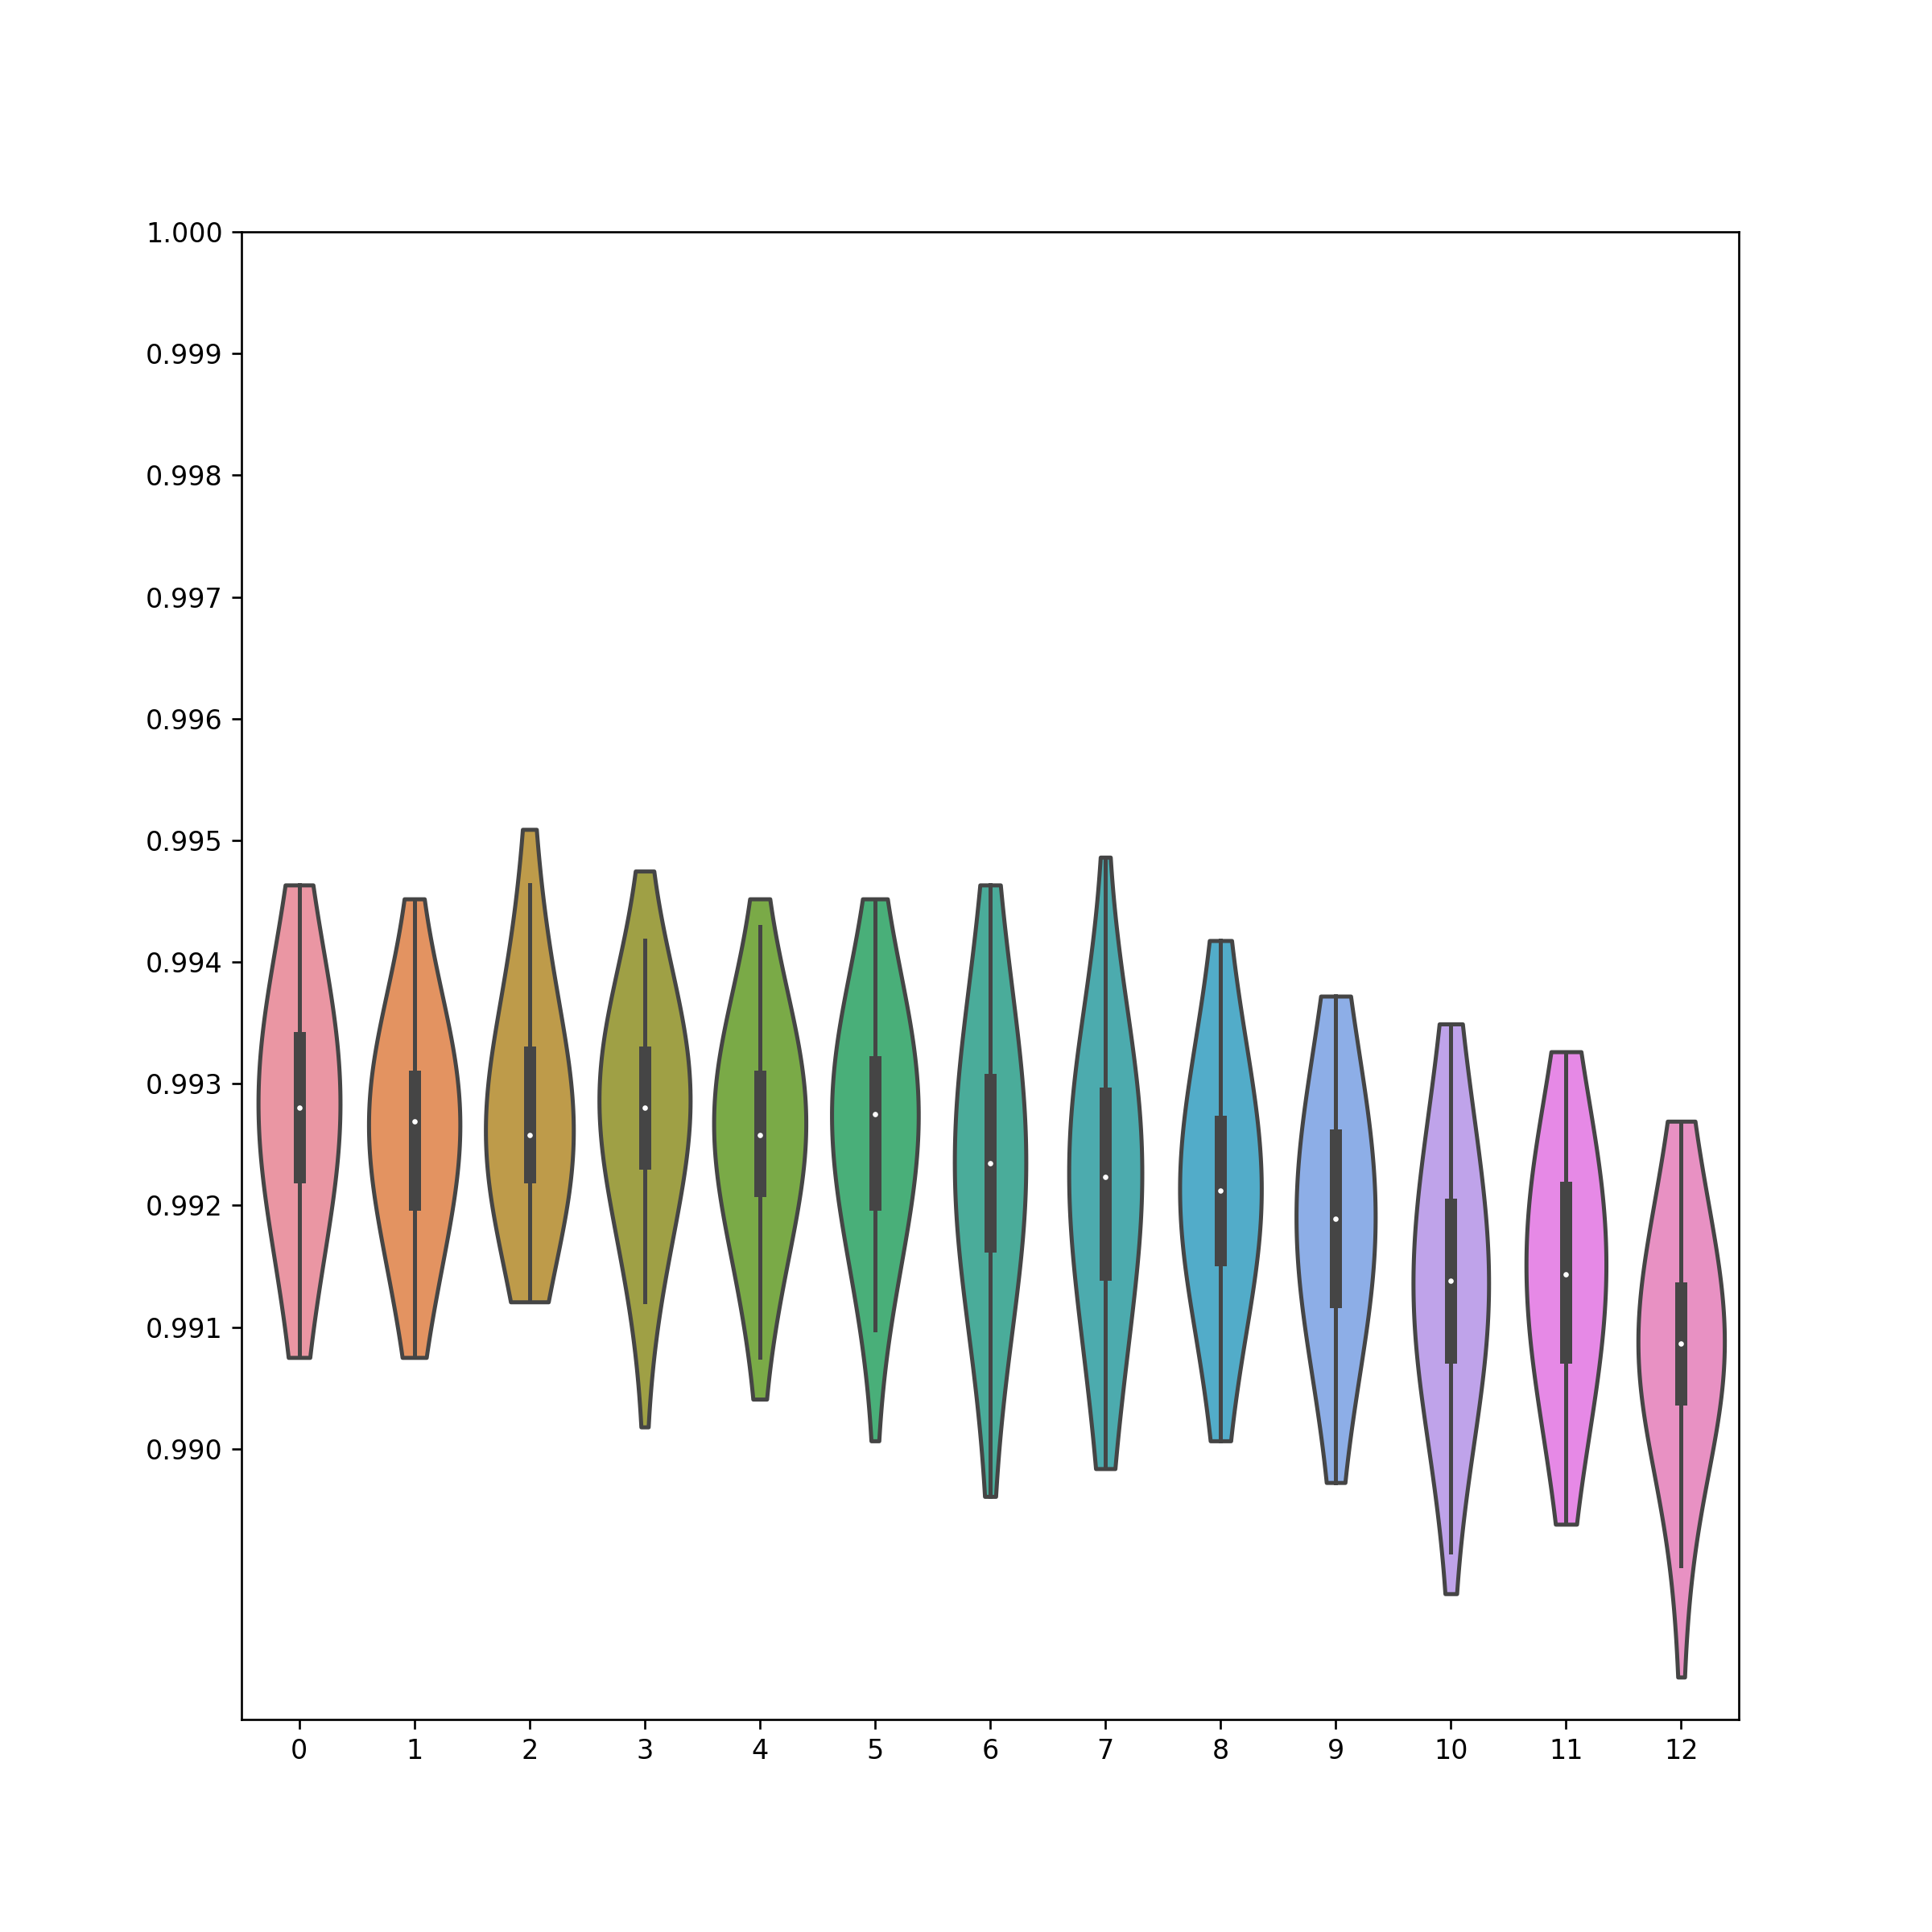

In [210]:
res2 = []
for i in range(60, 40, -2):
    res2.append(results[str(i)])
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.violinplot(data=res2, orient='v', cut=0, bw=1)
plt.yticks(np.arange(0.99, 1, 0.001))
plt.show()

### Choosing hyperparameters - n_estimators, max_features, max_depth

In [45]:
crossval_estimators = np.linspace(1, 100, 10, dtype=np.int64)
crossval_max_features = np.linspace(5, 30, 10, dtype=np.int64)
crossval_max_depth = np.linspace(2, 30, 10, dtype=np.int64)
vals = []
tests = []
for max_features in crossval_max_features:
    for estimators in crossval_estimators:
        for depth_tree in crossval_max_depth:
            vals.append([])
            tests.append([])

            for _ in tqdm(range(30)):
                X_train, X_val, y_train, y_val = train_test_split(
                    dframe, labels, test_size=0.2, stratify=groups
                )
                m_train = list(map(int, X_train.index))
                m_val = list(map(int, X_val.index))

                clf = RandomForestClassifier(n_estimators=estimators, max_features=max_features, max_depth=depth_tree, n_jobs=8)
                clf.fit(X_train, y_train)
                pred = clf.predict(X_val)
                vals[-1].append(accuracy_score(pred, y_val))
                pred = clf.predict(X_train)
                tests[-1].append(accuracy_score(pred, y_train))




  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:00<00:05,  5.68it/s]


  7%|▋         | 2/30 [00:00<00:04,  5.62it/s]


 10%|█         | 3/30 [00:00<00:04,  5.50it/s]


 13%|█▎        | 4/30 [00:00<00:04,  5.50it/s]


 17%|█▋        | 5/30 [00:00<00:04,  5.52it/s]


 20%|██        | 6/30 [00:01<00:04,  5.54it/s]


 23%|██▎       | 7/30 [00:01<00:04,  5.54it/s]


 27%|██▋       | 8/30 [00:01<00:03,  5.53it/s]


 30%|███       | 9/30 [00:01<00:03,  5.53it/s]


 33%|███▎      | 10/30 [00:01<00:03,  5.54it/s]


 37%|███▋      | 11/30 [00:01<00:03,  5.55it/s]


 40%|████      | 12/30 [00:02<00:03,  5.56it/s]


 43%|████▎     | 13/30 [00:02<00:03,  5.60it/s]


 47%|████▋     | 14/30 [00:02<00:02,  5.60it/s]


 50%|█████     | 15/30 [00:02<00:02,  5.59it/s]


 53%|█████▎    | 16/30 [00:02<00:02,  5.57it/s]


 57%|█████▋    | 17/30 [00:03<00:02,  5.57it/s]


 60%|██████    | 18/30 [00:03<00:02,  5.58it/s]


 63%|██████▎   | 19/30 [00:03<00:01,  5.58it/s]




KeyboardInterrupt: 

<IPython.core.display.Javascript object>


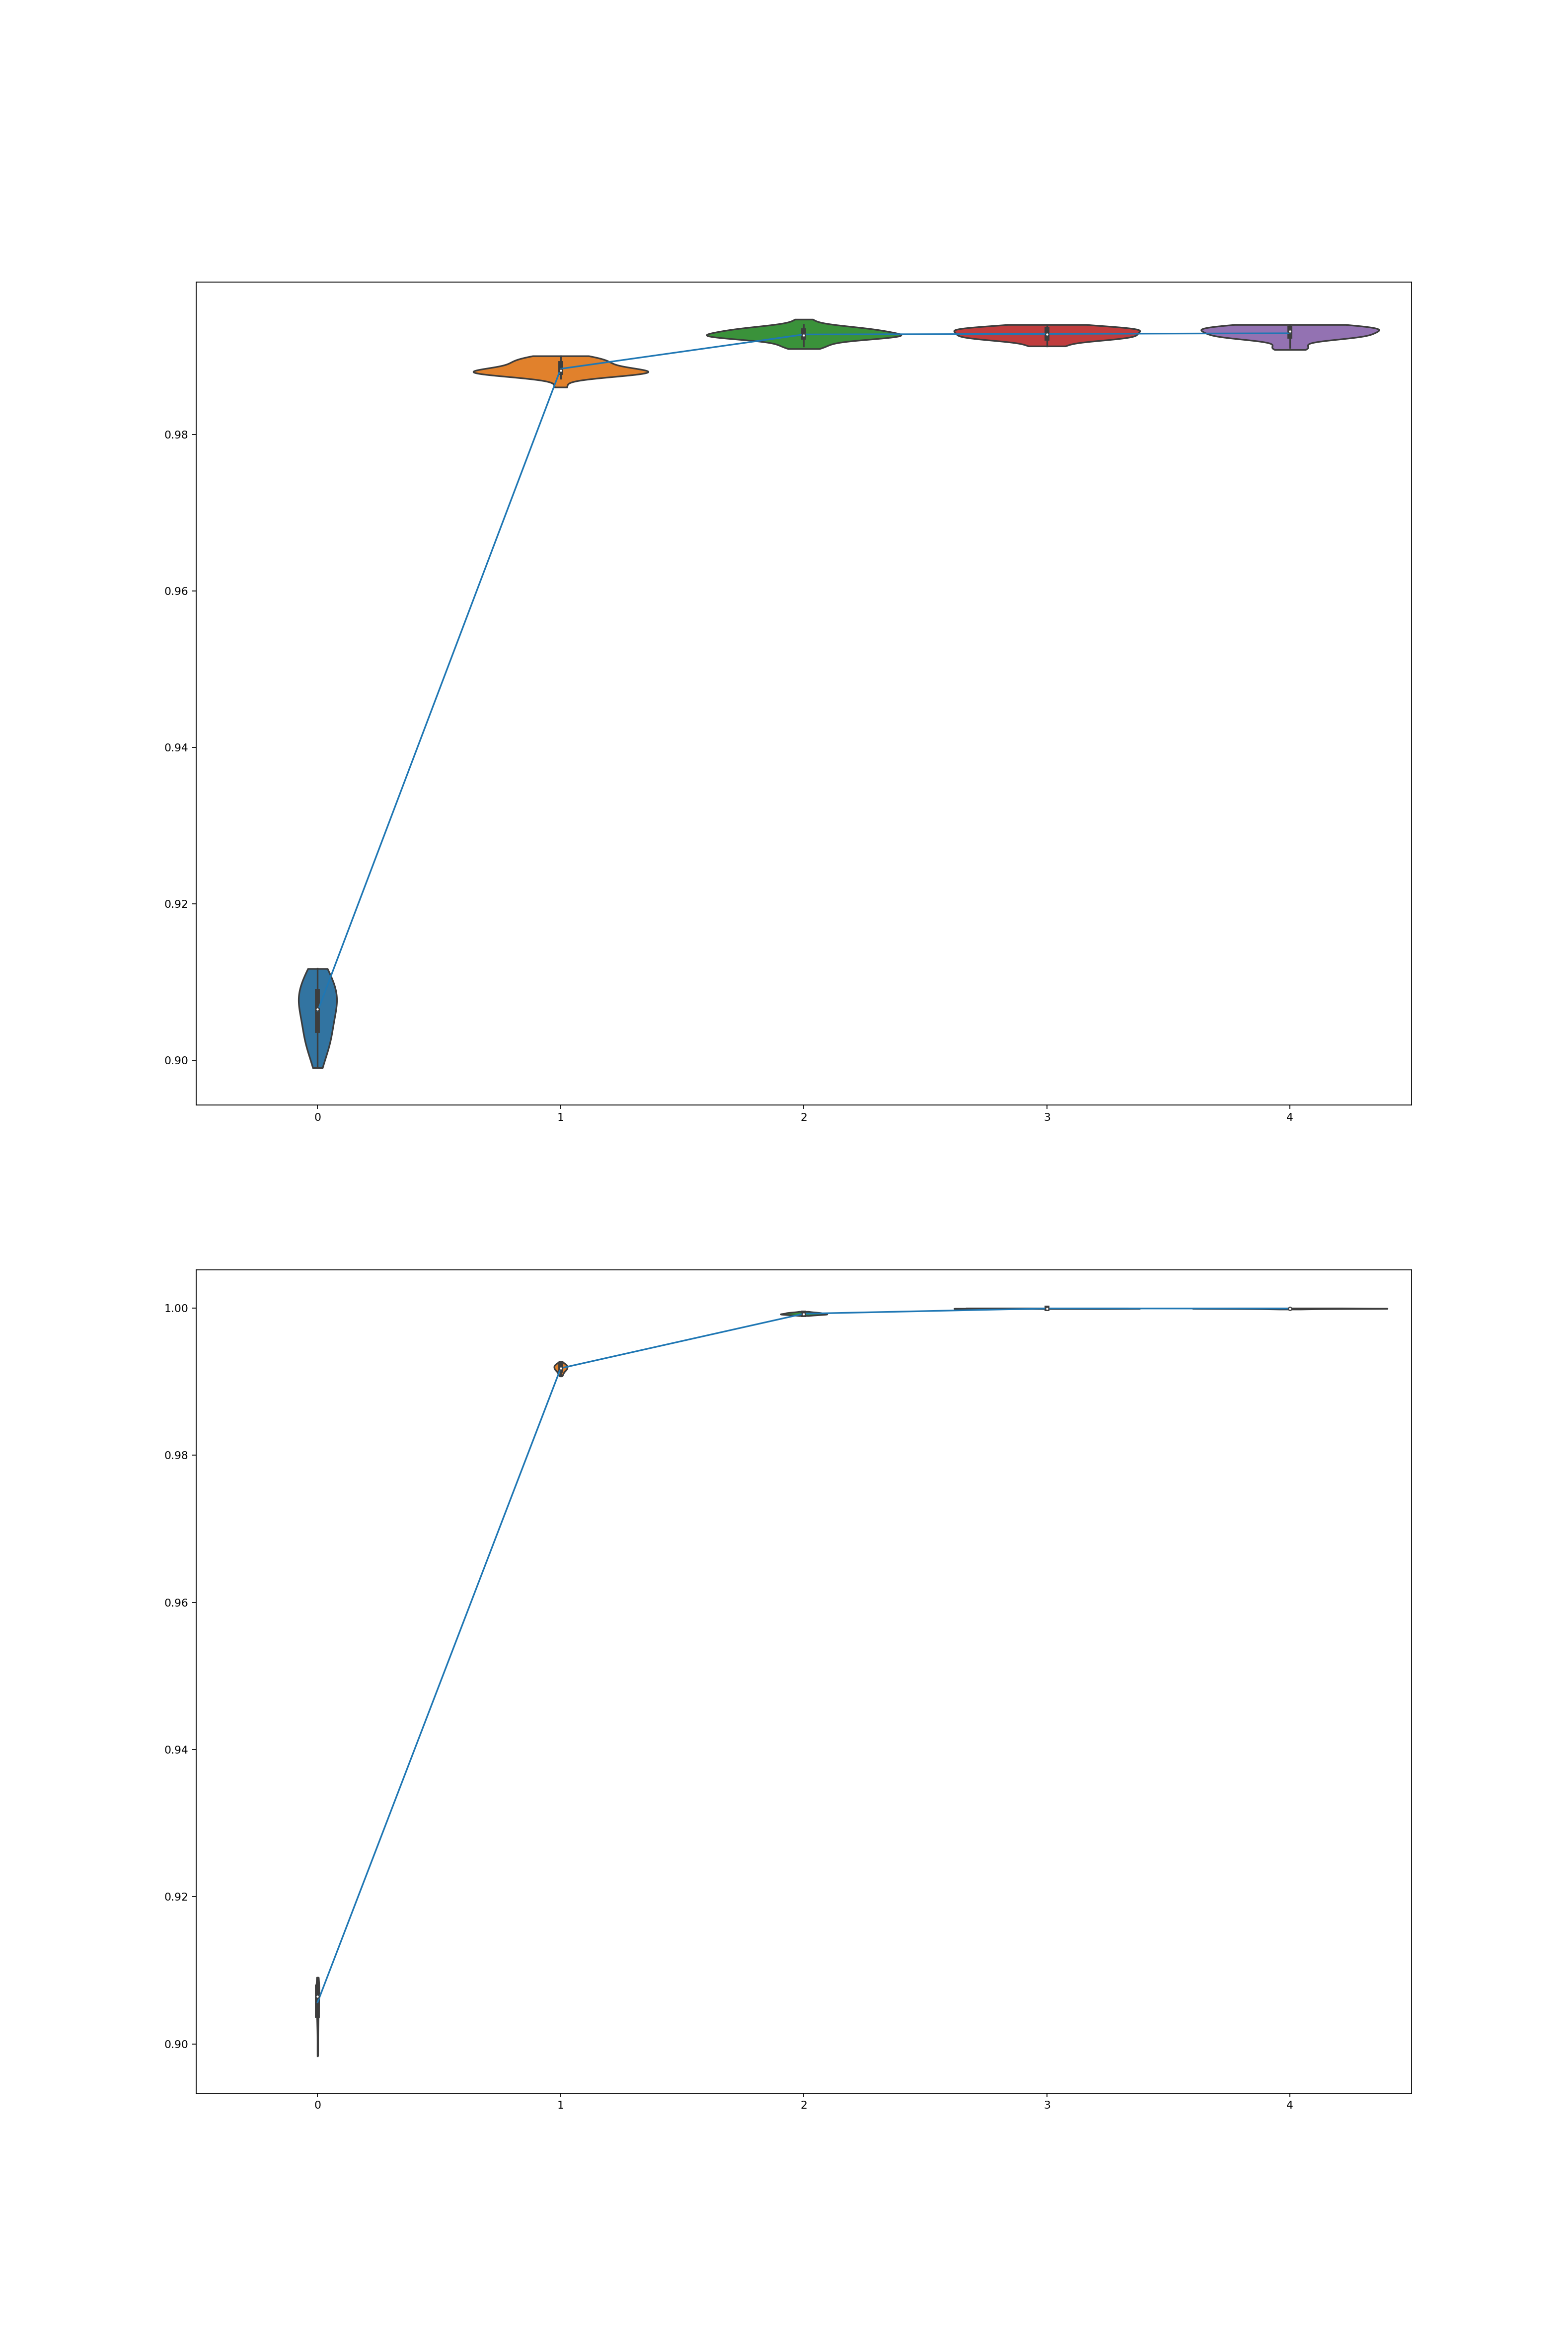

0
1


In [33]:
np.savez('NN_lsize_big', vals=vals, tests=tests)
NN_lsize = np.load('NN_lsize_big.npz')
f, ax = plt.subplots(2, figsize=(20, 30))
for i, test in enumerate(['vals', 'tests']):
    data = NN_lsize[test]
    sns.violinplot(data=data.T, orient='v', ax=ax[i], cut=0)
    print(i)
    ax[i].plot(np.arange(data.shape[0]), data.mean(axis=1))
plt.show()

### Boosting model - AdaBoost

In [80]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=estimators)
clf.fit(dframe, labels)
joblib.dump(clf, '../model_ada.pkl')

['../model_ada.pkl']